# Машинное обучение, ФКН ВШЭ

## Практическое задание 7. Градиентный бустинг ~~своими руками~~

### Общая информация
Дата выдачи: 04.12.2019

Мягкий дедлайн: 05:59MSK 15.12.2019

Жесткий дедлайн: 05:59MSK 17.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15.5 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

__Задание 1. (0.5 балла)__

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [1]:
import pandas as pd

# from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('application_train.csv', index_col=0)
y = data.TARGET.values
data = data.drop('TARGET', axis=1)

In [3]:
# data.dtypes.values != 'object'
data = data.drop(columns=data.columns[data.dtypes.values == 'object'], axis=1)

In [4]:
data = data.fillna(data.mean())

In [5]:
data.isna().sum()

CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
AMT_ANNUITY                   0
AMT_GOODS_PRICE               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 104, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.7, random_state=0)

__Задание 2. (1.5 балла)__

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [7]:
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from time import time
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# LightGBM

In [8]:
start_time = time()
clf = LGBMClassifier().fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
end_time = time()
print("PR-AUC:", auc(recall, precision))
print("Time:", end_time - start_time, "seconds")

PR-AUC: 0.2212805320009123
Time: 2.6543989181518555 seconds


# CatBoost

In [9]:
start_time = time()
clf = CatBoostClassifier().fit(X_train, y_train, verbose=200)
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
end_time = time()
print("PR-AUC:", auc(recall, precision))
print("Time:", end_time - start_time, "seconds")

Learning rate set to 0.054497
0:	learn: 0.6367119	total: 90.2ms	remaining: 1m 30s
200:	learn: 0.2411002	total: 5.05s	remaining: 20.1s
400:	learn: 0.2297630	total: 10.9s	remaining: 16.3s
600:	learn: 0.2203795	total: 17.1s	remaining: 11.3s
800:	learn: 0.2118536	total: 21.8s	remaining: 5.42s
999:	learn: 0.2042400	total: 26.2s	remaining: 0us
PR-AUC: 0.22415000602859464
Time: 26.705607175827026 seconds


__Задание 3. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть в семинаре про библиотеки.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма. 

# Cat boost

In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [13]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500]
quals_train = []
quals_test = []
for n in tqdm(n_trees):
    clf = CatBoostClassifier(n_estimators=n, logging_level='Silent')
    clf.fit(X_train, y_train)
    precision, recall, thresholds = precision_recall_curve(y_train, clf.predict_proba(X_train)[:, 1])
    q_train = auc(recall, precision)
    precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    q_test = auc(recall, precision)
    quals_train.append(q_train)
    quals_test.append(q_test)

100%|██████████| 8/8 [00:38<00:00,  4.76s/it]


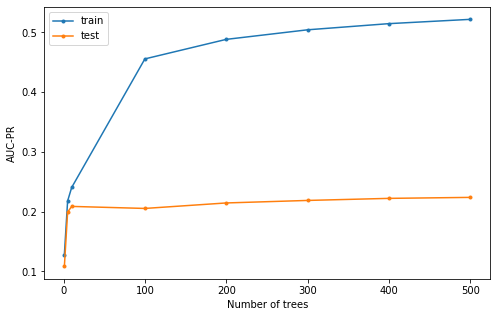

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-PR')
plt.legend()

plt.show()

In [15]:
best_found_am_trees = n_trees[np.argmax(quals_test)]

In [16]:
depth = list(range(1, 14, 2))
n_trees = best_found_am_trees
quals_train = []
quals_test = []
for d in tqdm(depth):
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    precision, recall, thresholds = precision_recall_curve(y_train, clf.predict_proba(X_train)[:, 1])
    q_train = auc(recall, precision)
    precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    q_test = auc(recall, precision)
    quals_train.append(q_train)
    quals_test.append(q_test)

100%|██████████| 7/7 [12:21<00:00, 105.90s/it]


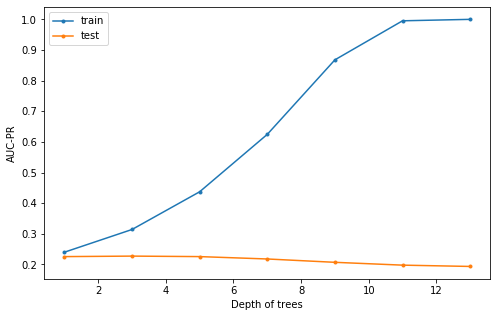

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-PR')
plt.legend()

plt.show()

In [18]:
best_found_depth = depth[np.argmax(quals_test)]

# LightGBM

In [19]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in tqdm(n_trees):
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    precision, recall, thresholds = precision_recall_curve(y_train, clf.predict_proba(X_train)[:, 1])
    q_train = auc(recall, precision)
    precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    q_test = auc(recall, precision)
    quals_train.append(q_train)
    quals_test.append(q_test)

100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


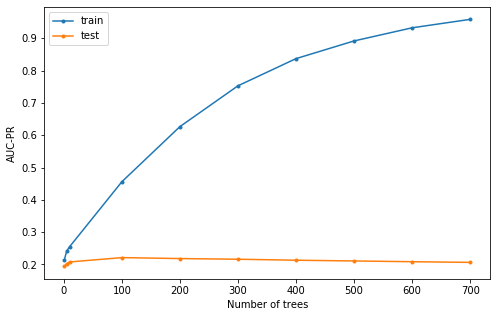

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-PR')
plt.legend()

plt.show()

In [21]:
best_found_am_trees_lightgbm = n_trees[np.argmax(quals_test)]

In [24]:
depth = list(range(1, 22, 3))
n_trees = best_found_am_trees
quals_train = []
quals_test = []
for d in tqdm(depth):
    clf = LGBMClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    precision, recall, thresholds = precision_recall_curve(y_train, clf.predict_proba(X_train)[:, 1])
    q_train = auc(recall, precision)
    precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    q_test = auc(recall, precision)
    quals_train.append(q_train)
    quals_test.append(q_test)



  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:04<00:25,  4.22s/it]

 29%|██▊       | 2/7 [00:10<00:23,  4.79s/it]

 43%|████▎     | 3/7 [00:18<00:23,  5.75s/it]

 57%|█████▋    | 4/7 [00:25<00:18,  6.32s/it]

 71%|███████▏  | 5/7 [00:33<00:13,  6.55s/it]

 86%|████████▌ | 6/7 [00:40<00:06,  6.73s/it]

100%|██████████| 7/7 [00:47<00:00,  6.81s/it]


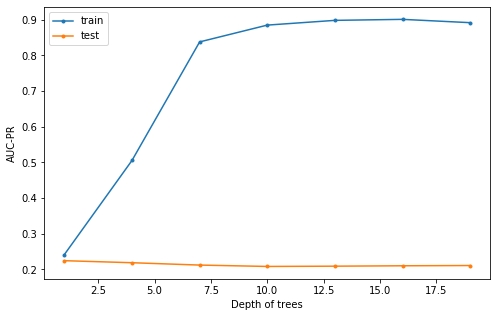

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-PR')
plt.legend()

plt.show()

In [26]:
best_found_depth_lightgbm = depth[np.argmax(quals_test)]

__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [202]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [203]:
data = pd.read_csv('application_train.csv', index_col=0)
y = data.TARGET.values
# data = data.drop('TARGET', axis=1)
categorical = data.columns[data.dtypes.values == 'object']

## Counters

In [204]:
def counters_with_smoothing(data, feature, target, constant):
    global_mean = data[target].mean()
    agg = data.groupby(feature)[target].agg(['mean', 'count'])
    amount_of_this_value, mean_of_this_value = agg['count'], agg['mean']
    counter_with_smoothing = (amount_of_this_value * mean_of_this_value + constant * global_mean)
    counter_with_smoothing /= (amount_of_this_value + constant)
    return data[feature].map(counter_with_smoothing)

In [205]:
# for feature in categorical:
#     data[feature] = data[feature].map(data.groupby(feature)['TARGET'].mean())

In [206]:
for feature in categorical:
    data[feature] = counters_with_smoothing(data=data, feature=feature, target='TARGET', constant=10)

In [207]:
data = data.drop('TARGET', axis=1)

In [208]:
data.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
247330,0.083693,0.070096,0.085396,0.083726,0,157500.0,706410.0,67072.5,679500.0,0.081886,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
425716,0.083693,0.070096,0.072184,0.079642,1,121500.0,545040.0,25407.0,450000.0,0.081886,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
331625,0.083693,0.101627,0.072184,0.079642,1,225000.0,942300.0,27679.5,675000.0,0.081886,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
455397,0.054398,0.070096,0.085396,0.079642,2,144000.0,180000.0,9000.0,180000.0,0.081886,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
449114,0.083693,0.070096,0.085396,0.079642,0,112500.0,729792.0,37390.5,630000.0,0.081886,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [209]:
y.mean()

0.08088935551457095

In [210]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.7, random_state=0)

In [211]:
start_time = time()
clf = LGBMClassifier(n_estimators=best_found_am_trees_lightgbm, max_depth=best_found_depth_lightgbm, logging_level="Silent").fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
end_time = time()
print("LightGBM with counters PR-AUC:", auc(recall, precision))
print("LightGBM with counters Time:", end_time - start_time, "seconds")

LightGBM with counters PR-AUC: 0.21374334679754414
LightGBM with counters Time: 1.6622707843780518 seconds


In [212]:
start_time = time()
clf = CatBoostClassifier(n_estimators=best_found_am_trees, max_depth=best_found_depth, logging_level="Silent").fit(X_train, y_train, verbose=200)
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
end_time = time()
print("CatBoost with counters PR-AUC:", auc(recall, precision))
print("CatBoost with counters Time:", end_time - start_time, "seconds")

Learning rate set to 0.101063
0:	learn: 0.5977576	total: 18.9ms	remaining: 9.41s
200:	learn: 0.2439802	total: 3.42s	remaining: 5.09s
400:	learn: 0.2383106	total: 7.35s	remaining: 1.81s
499:	learn: 0.2358699	total: 9.15s	remaining: 0us
CatBoost with counters PR-AUC: 0.2339479819144274
CatBoost with counters Time: 9.508089780807495 seconds


## Built-in methods

In [213]:
data = pd.read_csv('application_train.csv', index_col=0)
y = data.TARGET.values
# data = data.drop('TARGET', axis=1)
categorical = data.columns[data.dtypes.values == 'object']

In [214]:
from sklearn import preprocessing
labelEncoder = preprocessing.LabelEncoder()
data[categorical] = data[categorical].fillna("")
 
for feature in categorical:
    labelEncoder.fit(data[feature])
    feature_classes = list(labelEncoder.classes_)
    encoded_feature = labelEncoder.transform(data[feature])
    data[feature] = pd.DataFrame(encoded_feature)

In [215]:
# i, = np.where(data[].unique() == "Cash loans")
# i
# data[categorical[4]].unique()

In [216]:
# feature = categorical[4]
# a = data[feature].unique()
# b = data[feature]

# import numpy_indexed as npi
# # all(i == npi.indices(a, b))
# sum(npi.indices(a, b) == 5)

In [217]:
# for feature in categorical:
#     a = data[feature].unique()
#     b = data[feature]
#     data[feature] = npi.indices(a, b)

In [218]:
data = data.drop('TARGET', axis=1)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.7, random_state=0)

In [220]:
categorical.values

array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'], dtype=object)

In [221]:
start_time = time()
clf = LGBMClassifier(n_estimators=best_found_am_trees_lightgbm, max_depth=best_found_depth_lightgbm, logging_level="Silent").fit(X_train, y_train, categorical_feature=list(categorical.values))
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
end_time = time()
print("LightGBM with Built-in methods PR-AUC:", auc(recall, precision))
print("LightGBM with Built-in methods Time:", end_time - start_time, "seconds")

LightGBM with Built-in methods PR-AUC: 0.21026908936635275
LightGBM with Built-in methods Time: 1.844447135925293 seconds


In [222]:
categorical_features_indices = np.where(data.dtypes == np.object)[0]

In [223]:
start_time = time()
clf = CatBoostClassifier(n_estimators=best_found_am_trees, max_depth=best_found_depth, logging_level="Silent").fit(X_train, y_train, verbose=200)
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
end_time = time()
print("CatBoost with Built-in methods PR-AUC:", auc(recall, precision))
print("CatBoost with Built-in methods Time:", end_time - start_time, "seconds")

Learning rate set to 0.101063
0:	learn: 0.5971838	total: 21.9ms	remaining: 10.9s
200:	learn: 0.2461424	total: 4.38s	remaining: 6.51s
400:	learn: 0.2402497	total: 8.19s	remaining: 2.02s
499:	learn: 0.2378665	total: 11s	remaining: 0us
CatBoost with Built-in methods PR-AUC: 0.22730052212036556
CatBoost with Built-in methods Time: 11.399245977401733 seconds


## OHE

In [224]:
data = pd.read_csv('application_train.csv', index_col=0)
y = data.TARGET.values
data = data.drop('TARGET', axis=1)

categorical = data.columns[data.dtypes.values == 'object']
data[categorical] = data[categorical].fillna("")

In [225]:
ohe_array = OneHotEncoder(handle_unknown="ignore").fit_transform(data[categorical]).toarray()
categorical_data = data[categorical].copy()
ohe_data = data.drop(categorical, axis = 1).copy()
ohe_data = np.hstack((ohe_data, ohe_array))

In [226]:
X_train, X_test, y_train, y_test = train_test_split(ohe_data, y, test_size=0.7, random_state=0)

In [227]:
start_time = time()
clf = LGBMClassifier(n_estimators=best_found_am_trees_lightgbm, max_depth=best_found_depth_lightgbm, logging_level="Silent").fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
end_time = time()
print("LightGBM with ohe methods PR-AUC:", auc(recall, precision))
print("LightGBM with ohe methods Time:", end_time - start_time, "seconds")

LightGBM with ohe methods PR-AUC: 0.21195133031665797
LightGBM with ohe methods Time: 1.2996809482574463 seconds


In [228]:
start_time = time()
clf = CatBoostClassifier(n_estimators=best_found_am_trees_lightgbm, max_depth=best_found_depth_lightgbm, logging_level="Silent").fit(X_train, y_train, verbose=200)
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
end_time = time()
print("CatBoost with ohe methods PR-AUC:", auc(recall, precision))
print("CatBoost with ohe methods Time:", end_time - start_time, "seconds")

Learning rate set to 0.42401
0:	learn: 0.3882686	total: 16.2ms	remaining: 1.6s
99:	learn: 0.2486014	total: 1.5s	remaining: 0us
CatBoost with ohe methods PR-AUC: 0.22189972845927983
CatBoost with ohe methods Time: 8.917090892791748 seconds


__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество. Обратите внимание на данные, на которых обучаются 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог, с которого начинается "хвост" менее важных признаков) и обучите модель с теми же параметрами на получившихся данных. Сильно ли упало качество при удалении признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### Бонус

__Задание 7. (Максимум 5 баллов)__

Градиентный бустинг при всех ограничениях зачастую является ультимативным решением для задач с табличными данными; соревнование от Home Credit не стало исключением. Предлагается любыми модификациями Catboost и LightGBM (другими моделями пользоваться нельзя), обработки данных и построения признаков получить высокое качество на __приватном__ наборе данных. 
Баллы можно получить за следующие значения метрики в inclass-соревновании на Kaggle:
* 0.7955 - 1 балл
* 0.7975 - 3 баллов
* 0.80 - 5 баллов.

При сдаче этого задания необходимо приложить код, с помощью которого можно получить ту же самую метрику, что и в вашем посылке в соревновании. Если решение не будет воспроизводимым, задание засчитано не будет.

Учетная запись на kaggle: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Задание 8. (0.5 балла)__ Обратите внимание, что в соревновании метрикой выступает AUC-ROC, у нас же до этого оптимизировался AUC-PR. Можно ли утверждать, что нет необходимости в переобучении моделей для максимизации новой метрики, если мы нашли лучший алгоритм с точки зрения AUC-PR?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ